In [1]:
import numpy as np 
import pandas as pd
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim import SGD,  Adam
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from PIL import Image
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
class FlowerDataset(Dataset):
    def __init__(self, transform = None, list_dir = None, label = None, threshold = None):
        self.data = []
        for dir in list_dir[:threshold]:
            img = cv2.imread(dir)
            img = transform(img)
            self.data.append([img, label])
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

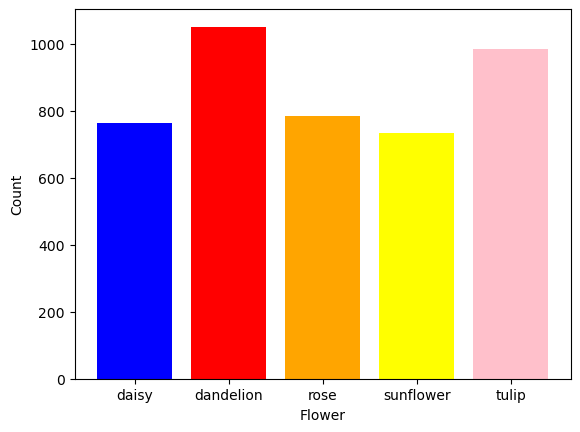

In [3]:
path_daisy = 'dataset_flower/training/daisy'
path_dandelion = 'dataset_flower/training/dandelion'
path_rose = 'dataset_flower/training/rose'
path_sunflower = 'dataset_flower/training/sunflower'
path_tulip = 'dataset_flower/training/tulip'
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64)), transforms.Normalize((0.0, ), (1.0, ))])
dataset_daisy = FlowerDataset(transform = transform, label = 0, list_dir = list(paths.list_images(path_daisy)))
dataset_dandelion = FlowerDataset(transform = transform, label = 1, list_dir = list(paths.list_images(path_dandelion)))
dataset_rose = FlowerDataset(transform = transform, label = 2, list_dir = list(paths.list_images(path_rose)))
dataset_sunflower = FlowerDataset(transform = transform, label = 3, list_dir = list(paths.list_images(path_sunflower)))
dataset_tulip = FlowerDataset(transform = transform, label = 4, list_dir = list(paths.list_images(path_tulip)))
plt.bar(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], 
        [dataset_daisy.__len__(), dataset_dandelion.__len__(), dataset_rose.__len__(), dataset_sunflower.__len__(), dataset_tulip.__len__()], 
        color = ['blue', 'red', 'orange', 'yellow', 'pink'])
plt.xlabel('Flower')
plt.ylabel('Count')
plt.show()

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3))
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3))
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3))
        self.max_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(128 * 6 * 6 , 512)
        self.linear2 = nn.Linear(512, 5)
        self.drop = nn.Dropout(p = 0.5)
        # self.bn = 
        
    def forward(self, x):
        x = self.max_pool(self.activation(self.conv1(x)))
        x = self.drop(x)
        x = self.max_pool(self.activation(self.conv2(x)))
        x = self.drop(x)
        x = self.max_pool(self.activation(self.conv3(x)))
        x = self.drop(x)
        x = x.view(-1, 128 * 6 * 6)
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x

In [51]:
dataset_target = dataset_daisy.data + dataset_dandelion.data + dataset_rose.data + dataset_sunflower.data + dataset_tulip.data
print(len(dataset_target))
train_size = int(0.8 * dataset_target.__len__())
validation_size = len(dataset_target) - (train_size)
train_dataset, validation_dataset = random_split(dataset_target, [train_size, validation_size])
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)

4317


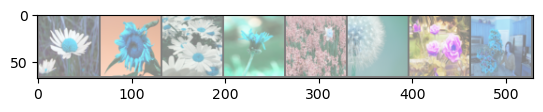

In [52]:
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(train_dataloader, 0):
    imshow(torchvision.utils.make_grid(images[:8])) 
    break

In [53]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr = 0.01)
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (linear1): Linear(in_features=4608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [54]:
max_epochs = 250
train_losses, test_losses, test_accuracy = [], [], []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    total = 0
    correct = 0
    for img, label in train_dataloader:
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    
    # Evaluate model
    model.eval()
    test_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for img, label in validation_dataloader:
            outputs = model(img)
            loss = criterion(outputs, label)
            test_loss += loss.item()
            _, y_hat = torch.max(outputs, 1)
            total += label.size(0)
            correct += (y_hat == label).sum().item()
    test_loss /= len(validation_dataloader)
    test_losses.append(test_loss)
    accuracy = correct / total
    test_accuracy.append(accuracy)
    print(f'Epoch {epoch + 1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')
torch.save(model.state_dict(), 'model.pth')

Epoch 1/250, Train Loss: 1.6036, Test Loss: 1.6038, Test Accuracy: 0.2720
Epoch 2/250, Train Loss: 1.5998, Test Loss: 1.6009, Test Accuracy: 0.2720
Epoch 3/250, Train Loss: 1.5973, Test Loss: 1.5992, Test Accuracy: 0.2720
Epoch 4/250, Train Loss: 1.5944, Test Loss: 1.5980, Test Accuracy: 0.2720
Epoch 5/250, Train Loss: 1.5928, Test Loss: 1.5961, Test Accuracy: 0.2720
Epoch 6/250, Train Loss: 1.5879, Test Loss: 1.5938, Test Accuracy: 0.2720
Epoch 7/250, Train Loss: 1.5836, Test Loss: 1.5908, Test Accuracy: 0.2731
Epoch 8/250, Train Loss: 1.5785, Test Loss: 1.5871, Test Accuracy: 0.2731
Epoch 9/250, Train Loss: 1.5714, Test Loss: 1.5819, Test Accuracy: 0.2731
Epoch 10/250, Train Loss: 1.5614, Test Loss: 1.5753, Test Accuracy: 0.2824
Epoch 11/250, Train Loss: 1.5502, Test Loss: 1.5679, Test Accuracy: 0.3090
Epoch 12/250, Train Loss: 1.5343, Test Loss: 1.5554, Test Accuracy: 0.3183
Epoch 13/250, Train Loss: 1.5198, Test Loss: 1.5411, Test Accuracy: 0.3345
Epoch 14/250, Train Loss: 1.4981, 

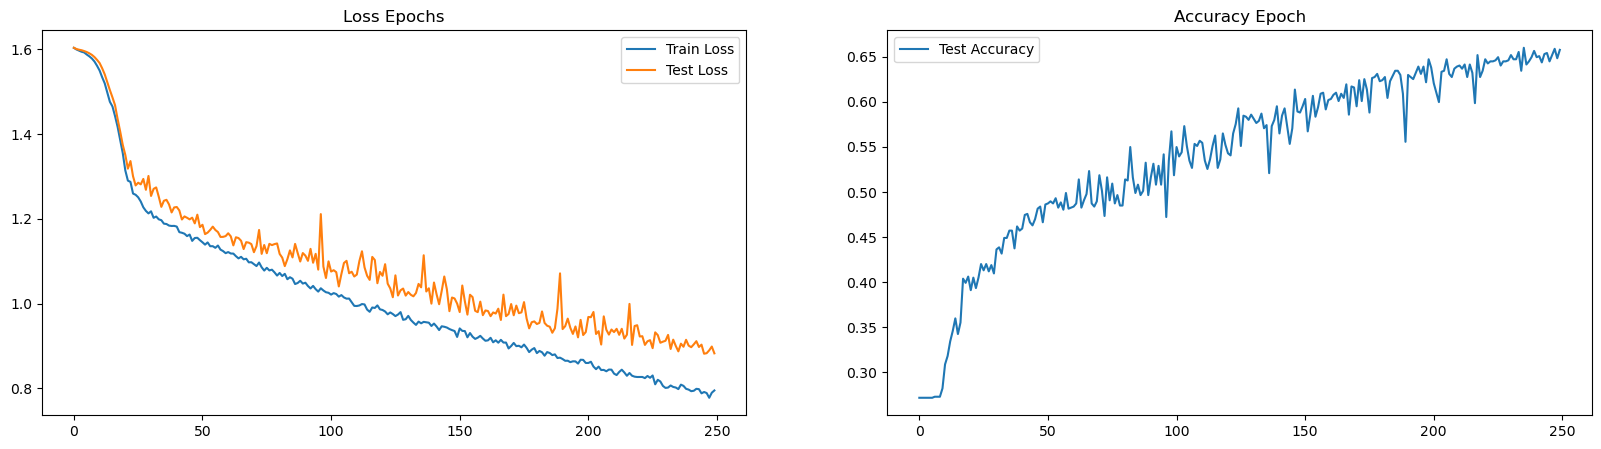

In [55]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()

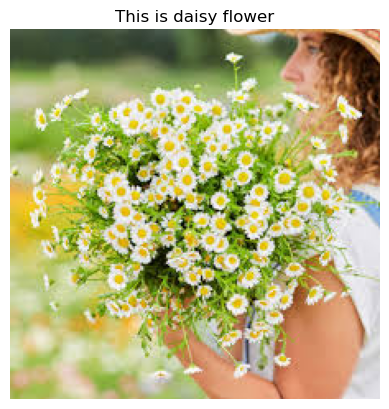

In [60]:
if __name__ == "__main__":
    path = input("Enter image path here: ")
    img = cv2.imread(path)
    new_img = transform(img)
    
    model.load_state_dict(torch.load('model.pth'))
    model.eval()
    with torch.no_grad():
        output = model(new_img)
        _, predicted = torch.max(output, 1)
    labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
    plt.title(f"This is {labels[predicted.item()]} flower")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()